In [1]:
#Libraries:
#Tensors:
import torch
import numpy as np

#Plotting in 2d/3d:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
import matplotlib.cm as cm
%matplotlib inline

#Tools:
from itertools import product, combinations
import sys
import math
from numpy import savetxt
import csv
import os 

sys.path.append("../../..")
import Kernel_and_GP_tools as GP
import My_Tools
import Tasks.GP_Data.GP_div_free_circle.loader as GP_load_data


In [2]:
Dataset=GP_load_data.give_GP_div_free_data_set(2,50,None,data_set='train',file_path='')
GP_parameters={'l_scale':0.5,
'sigma_var': 2., 
'kernel_type':"div_free",
'obs_noise':1e-4}

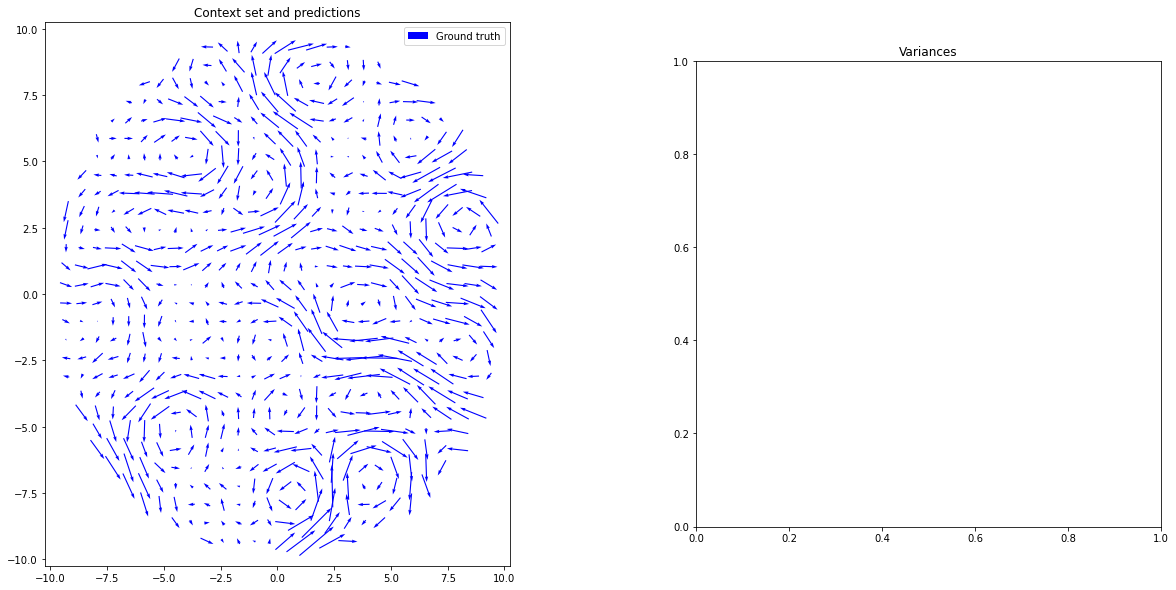

In [7]:
X_c,Y_c,X_t,Y_t=Dataset.get_rand_batch(batch_size=1,cont_in_target=True)
Means,Covs,Vars=GP.GP_inference(X_c[0],Y_c[0],X_t[0],**GP_parameters)
Covs=My_Tools.Get_Block_Diagonal(Covs,size=2)
My_Tools.Plot_Inference_2d(X_Context=None,Y_Context=None,X_Target=X_t[0],Y_Target=Y_t[0],quiver_scale=20)

[[-5.     -3.8889 -2.7778 -1.6667 -0.5556  0.5556  1.6667  2.7778  3.8889  5.    ]
 [-5.     -3.8889 -2.7778 -1.6667 -0.5556  0.5556  1.6667  2.7778  3.8889  5.    ]
 [-5.     -3.8889 -2.7778 -1.6667 -0.5556  0.5556  1.6667  2.7778  3.8889  5.    ]
 [-5.     -3.8889 -2.7778 -1.6667 -0.5556  0.5556  1.6667  2.7778  3.8889  5.    ]
 [-5.     -3.8889 -2.7778 -1.6667 -0.5556  0.5556  1.6667  2.7778  3.8889  5.    ]
 [-5.     -3.8889 -2.7778 -1.6667 -0.5556  0.5556  1.6667  2.7778  3.8889  5.    ]
 [-5.     -3.8889 -2.7778 -1.6667 -0.5556  0.5556  1.6667  2.7778  3.8889  5.    ]
 [-5.     -3.8889 -2.7778 -1.6667 -0.5556  0.5556  1.6667  2.7778  3.8889  5.    ]
 [-5.     -3.8889 -2.7778 -1.6667 -0.5556  0.5556  1.6667  2.7778  3.8889  5.    ]
 [-5.     -3.8889 -2.7778 -1.6667 -0.5556  0.5556  1.6667  2.7778  3.8889  5.    ]] [[-5.     -5.     -5.     -5.     -5.     -5.     -5.     -5.     -5.     -5.    ]
 [-3.8889 -3.8889 -3.8889 -3.8889 -3.8889 -3.8889 -3.8889 -3.8889 -3.8889 -3.8889]
 [-

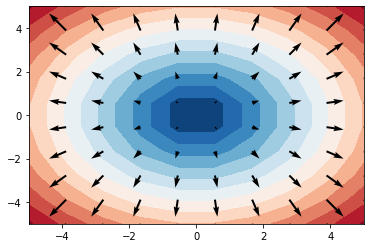

In [12]:
x,y = np.meshgrid(np.linspace(-5,5,10),np.linspace(-5,5,10))
print(x,y)
u = x#/np.sqrt(x**2 + y**2)
v = y#/np.sqrt(x**2 + y**2)
fig,ax=plt.subplots()
norm=np.sqrt(u**2+v**2)
#ax.contour(x,y,norm,colors='k')
cntr1 = ax.contourf(x, y, norm, levels=14, cmap="RdBu_r")
ax.quiver(x,y,u,v)


In [113]:
def meshgrid_to_vectors(X,Y):
    '''
    X,Y - torch.Tensor - shape (n,m)
    '''
    X=X.reshape(-1,1)
    Y=Y.reshape(-1,1)
    return(torch.cat([X,Y],dim=1))
def vectors_to_meshgrid(D,n,m=None):
    '''
    D - torch.Tensor - shape (n*m,2)
    '''
    if m is None:
        m=D.size(0)//n
    y=D[:m,1]
    x=D[:,0][torch.arange(0,D.size(0),m)]
    return(torch.meshgrid(x,y))
def get_2d_range(X):
    '''
    X - torch.Tensor - shape (*,2)
    '''
    X=X.reshape(-1,2)
    x1_max=torch.max(X[:,0])
    x1_min=torch.min(X[:,0])
    x2_max=torch.max(X[:,1])
    x2_min=torch.min(X[:,1])
    return(x1_min,x1_max,x2_min,x2_max)

def get_surrounding_grid(X,n_grid_points=20,stretch=0.2):
    x1_min,x1_max,x2_min,x2_max=get_2d_range(X)
    x1_ext=(x1_max-x1_min)*stretch/2
    x2_ext=(x2_max-x2_min)*stretch/2
    x1,x2 = torch.meshgrid(torch.linspace(x1_min-x1_ext,x1_max+x1_ext,n_grid_points),torch.linspace(x2_min-x2_ext,x2_max+x2_ext,   
                                                                                                        n_grid_points))
    X=meshgrid_to_vectors(x1,x2)
    return(x1,x2,X)

def plot_vf(fig,ax,x1,x2,X,Y,title=""):
    '''

    X - torch.Tensor - shape (n,2)
    Y - torch.Tensor - shape (n,2)
    '''
    n_grid_points=x1.size(0)
    norm=torch.norm(Y,dim=1).view(n_grid_points,n_grid_points)
    contour_plot=ax.contourf(x1, x2, norm, levels=14, cmap="RdBu_r",label='norm')
    ax.quiver(X[:,0],X[:,1],Y[:,0],Y[:,1],label=title)
    fig.colorbar(contour_plot,ax=ax)
    return(ax)

def plot_2d_gp_predict(fig,ax,x1,x2,X,x_context,y_context,GP_parameters,plot_context=True):
    Means,_,_=GP.GP_inference(x_context,y_context,X,**GP_parameters)
    ax=plot_vf(fig,ax,x1,x2,X,Means)
    if plot_context:
        ax.quiver(x_context[:,0],x_context[:,1],y_context[:,0],y_context[:,1],color='red',label='Context set')
    return(ax)

def plot_2d_cnp_predict(fig,ax,x1,x2,X,x_context,y_context,model,plot_context=True):
    Means,_,=model(x_context.unsqueeze(0),y_context.unsqueeze(0),X.unsqueeze(0))
    Means=Means.detach().squeeze()
    ax=plot_vf(fig,ax,x1,x2,X,Means)
    if plot_context:
        ax.quiver(x_context[:,0],x_context[:,1],y_context[:,0],y_context[:,1],color='red',label='Context set')
    return(ax)

def plot_model_comp(x_context,y_context,n_grid_points=20,Models=[],GP_parameters=None):
    '''
    x_context -torch.Tensor - shape (n,2)
    y_context - torch.Tensor -shape (n,2)
    '''

    x1,x2,X=get_surrounding_grid(x_context,n_grid_points=n_grid_points)
    
    n_comparisons=len(Models) if GP_parameters is None else len(Models)+1
    fig,axs=plt.subplots(ncols=n_comparisons,nrows=1,figsize=(n_comparisons*10,10))
    for it in range(len(Models)):
        axs[it]=plot_2d_cnp_predict(fig,axs[it],x1,x2,X,x_context,y_context,Models[it])
        axs[it].set_title("Model: "+str(it))

    if GP_parameters is not None:
        axs[-1]=plot_2d_gp_predict(fig,axs[-1],x1,x2,X,x_context,y_context,GP_parameters)
        axs[-1].set_title("GP inference")


In [114]:
'''
ENCODER
'''
#Set hyperparamters:
X_RANGE=[-4,4]
N_X_AXIS=20
L_SCALE_ENC=0.4
#Define the model:
Encoder=My_Models.Steerable_Encoder(l_scale=L_SCALE_ENC,x_range=X_RANGE,n_x_axis=N_X_AXIS)

'''
STEERABLE CNP
'''
#Set parameters for Steerable Decoder:
DIM_COV_EST=3
N=4
GEOM_KERNEL_SIZES=[7,9,11]
GEOM_NON_LINEARITY=['NormReLU']
HIDDEN_FIB_REPS=[[-1,-1],[-1,-1,1,1]]

geom_decoder=My_Models.Cyclic_Decoder(hidden_fib_reps=HIDDEN_FIB_REPS,kernel_sizes=GEOM_KERNEL_SIZES,dim_cov_est=DIM_COV_EST,non_linearity=GEOM_NON_LINEARITY,N=N)

#Set parameters for kernel dict out:
KERNEL_DICT_OUT_RBF={'kernel_type': 'rbf'}
KERNEL_DICT_OUT_DIV_FREE={'kernel_type': 'div_free'}

#Define two different cnps:
rbf_cnp=My_Models.Steerable_CNP(encoder=Encoder,decoder=geom_decoder,dim_cov_est=DIM_COV_EST,kernel_dict_out=KERNEL_DICT_OUT_RBF)
div_free_cnp=My_Models.Steerable_CNP(encoder=Encoder,decoder=geom_decoder,dim_cov_est=DIM_COV_EST,kernel_dict_out=KERNEL_DICT_OUT_DIV_FREE)

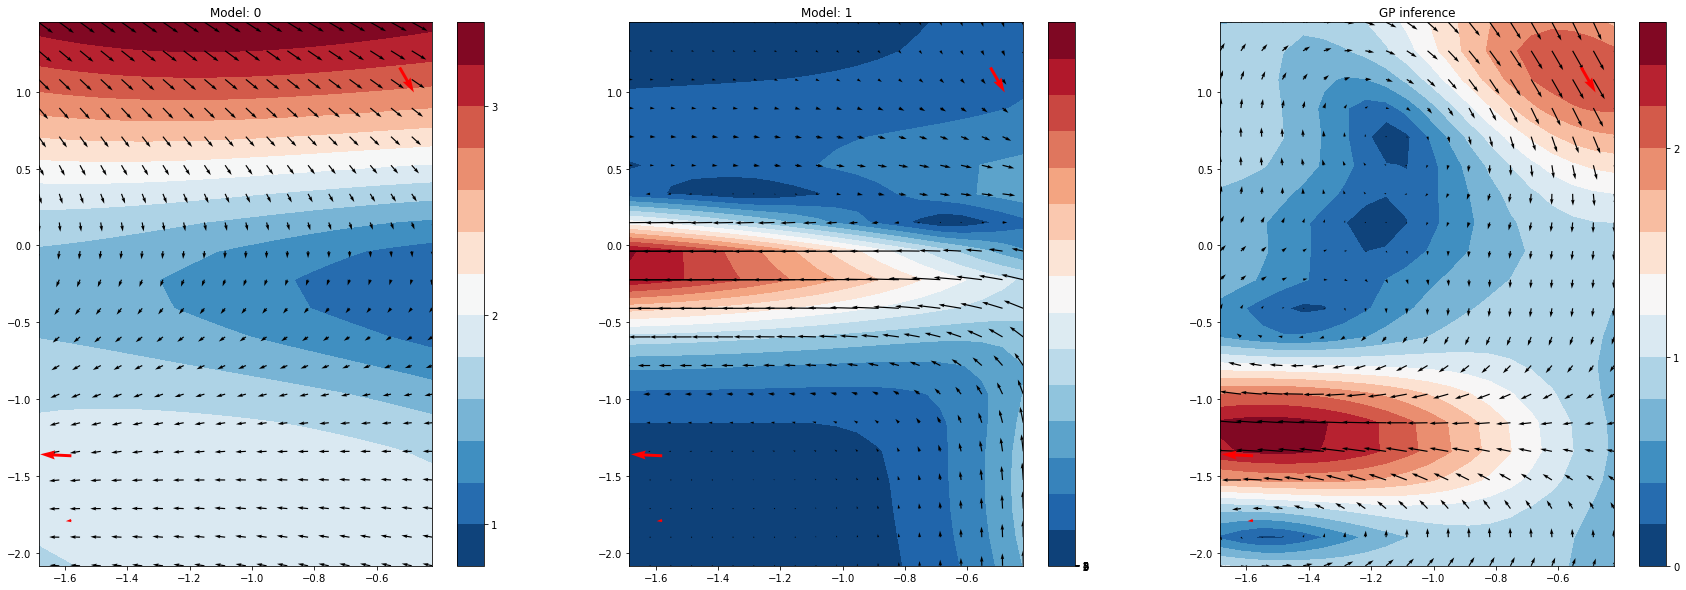

In [115]:
X_c,Y_c,X_t,Y_t=Dataset.get_rand_batch(batch_size=1,cont_in_target=True)

plot_model_comp(X_c[0],Y_c[0],n_grid_points=20,Models=[rbf_cnp,div_free_cnp],GP_parameters=GP_parameters)
